## Exploratory plots: temporal/spatial density, avg depth profiles

In [16]:
# %matplotlib qt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cartopy import crs, feature

import warnings
warnings.filterwarnings("ignore")

OUTPATH = './output'
IOPATH = '/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/CCS_obs.csv'

In [2]:
obs = pd.read_csv(IOPATH)
obs

,Unnamed: 0.1,Unnamed: 0,time,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),DO (umol kg-1),...,Zn (nmol kg-1),source,Nstar (umol kg-1),spice,density (kg m-3),current,location,[TA-DIC] (uM),NSdist,EWdist
0,0,0,1933-07-25 00:00:00+00:00,-126.76,49.34,1.0,1.008587,NaN,32.070847,NaN,...,NaN,ios bottle,NaN,NaN,NaN,shelf,shelf,NaN,0.000000,-0.0
1,1,1,1933-07-25 00:00:00+00:00,-126.76,49.34,2.0,2.017180,NaN,32.090943,NaN,...,NaN,ios bottle,NaN,NaN,NaN,shelf,shelf,NaN,0.000000,-0.0
2,2,2,1933-07-25 00:00:00+00:00,-126.76,49.34,4.0,4.034378,NaN,32.090906,NaN,...,NaN,ios bottle,NaN,NaN,NaN,shelf,shelf,NaN,0.000000,-0.0
3,3,3,1933-07-25 00:00:00+00:00,-126.76,49.34,6.0,6.051598,NaN,32.090870,NaN,...,NaN,ios bottle,NaN,NaN,NaN,shelf,shelf,NaN,0.000000,-0.0
4,4,4,1933-07-25 00:00:00+00:00,-126.76,49.34,10.0,10.086095,NaN,32.181305,NaN,...,NaN,ios bottle,NaN,NaN,NaN,shelf,shelf,NaN,0.000000,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378648,1378648,1402109,2024-11-18 00:00:00+00:00,-124.95,44.38,0.0,0.000000,12.713836,32.386146,312.025459,...,NaN,ooi,NaN,-0.251376,1024.310436,NaN,slope,NaN,484.541716,NaN
1378649,1378649,1402110,2024-11-18 00:00:00+00:00,-124.94,44.36,0.0,0.000000,12.712860,32.386131,NaN,...,NaN,ooi,NaN,-0.251582,1024.310612,NaN,slope,NaN,484.541716,NaN
1378650,1378650,1402111,2024-11-18 00:00:00+00:00,-124.57,46.99,0.0,0.000000,10.586080,32.728763,202.661375,...,NaN,ooi,NaN,-0.405998,1024.962794,shelf,shelf,NaN,215.824564,-0.0
1378651,1378651,1402112,2024-11-18 00:00:00+00:00,-124.56,46.99,0.0,0.000000,12.215222,32.245641,308.384776,...,NaN,ooi,NaN,-0.452611,1024.296731,shelf,shelf,NaN,215.824564,-0.0


In [3]:
pd.unique(obs['current'])

array(['shelf', nan, 'CC', 'CUC'], dtype=object)

In [44]:
# add year and month column
obs['time'] = pd.to_datetime(obs['time'])

obs['year'] = obs.time.dt.year
obs['months'] = obs.time.dt.month


In [46]:
# Setting up different currents
obs_shelf = obs[obs['current'] == 'shelf']
obs_cuc = obs[obs['current'] == 'CUC']
obs_cc = obs[obs['current'] == 'CC']

# make a 'dist' column of the distances we're actually going to use for each current
# for shelf and cuc its simply the NS dist

obs_cuc['dist'] = obs_cuc.NSdist
obs_shelf['dist'] = obs_shelf.NSdist

# for the CC its a bit more complicated
# first, just pick whatever line the point is closer to
abs_a = obs_cc.NSdist.abs()
abs_b = obs_cc.EWdist.abs()

obs_cc['dist'] = np.select(
    [
        abs_a < abs_b,       # a closer to zero
        abs_b < abs_a,       # b closer to zero
        abs_a.isna(),        # a NaN, take b
        abs_b.isna()         # b NaN, take a
    ],
    [
        obs_cc.NSdist,
        obs_cc.EWdist,
        obs_cc.EWdist,
        obs_cc.NSdist
    ],
    default=np.nan
)

# and then also default that anywhere that the NS dist is -ve, the EW distance should be taken
obs_cc.dist[obs_cc.NSdist < 0] = obs_cc.EWdist

## Plots to understand temporal and spatial resolution

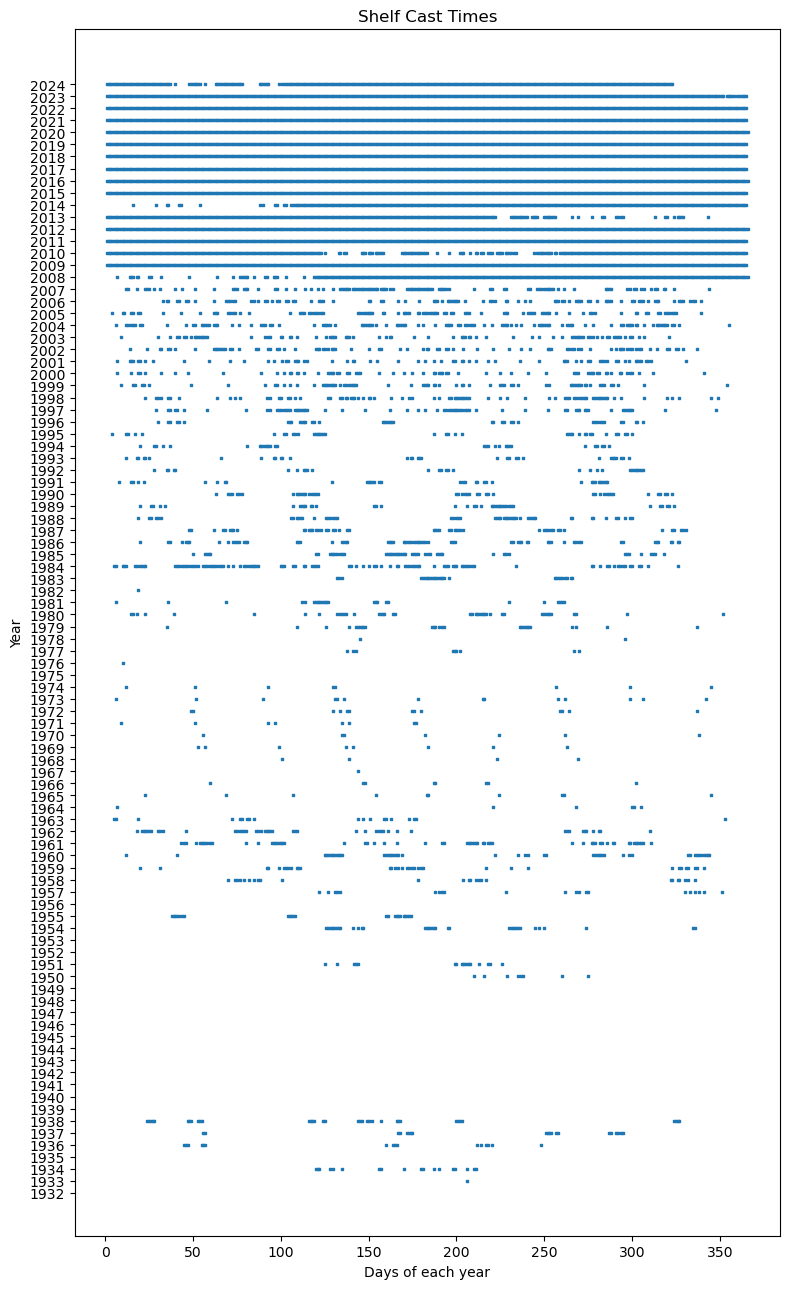

In [18]:
# Temporal resolution of Shelf Current
fig, ax = plt.subplots(figsize=(8, 13))

obs_shelf_dd = obs_shelf.drop_duplicates(subset='time', keep='first')

obs_shelf_dd['time'] = pd.to_datetime(obs_shelf_dd['time'])

yearDay = obs_shelf_dd['time'].dt.dayofyear
year = obs_shelf_dd['time'].dt.year

ax.scatter(yearDay, year, s=2, marker='s' )

ax.set_title('Shelf Cast Times')
ax.set_yticks(range(1932, 2025))  
ax.set_ylabel('Year')
ax.set_xlabel('Days of each year')

plt.tight_layout()
plt.show()

# Group by year and source, then count rows
grouped = obs_shelf.groupby(['year', 'source']).size().reset_index(name='count')

# Print results year by year
with open(OUTPATH+'/'+"ShelfCurrent_YearSource.txt", "w") as file:
    for year in sorted(grouped['year'].unique()):
        file.write(f"\n\nIn {year} there is:")
        sub = grouped[grouped['year'] == year]
        for _, row in sub.iterrows():
            file.write(f"\n    {row['source']}: {row['count']}")

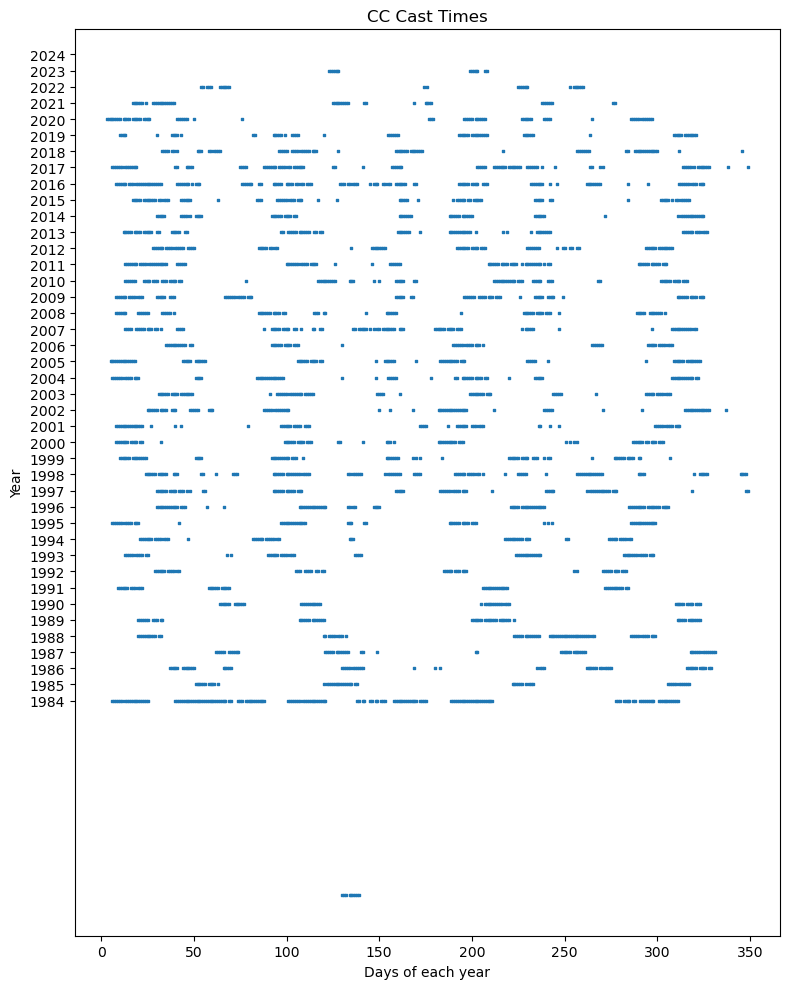

In [19]:
# Temporal resolution of California Current
fig, ax = plt.subplots(figsize=(8, 10))

obs_cc_dd = obs_cc.drop_duplicates(subset='time', keep='first')

obs_cc_dd['time'] = pd.to_datetime(obs_cc_dd['time'])

yearDay = obs_cc_dd['time'].dt.dayofyear
year = obs_cc_dd['time'].dt.year

ax.scatter(yearDay, year, s=2, marker='s' )
# ax.scatter(yearDay, year, s=2, marker='s', c=obs_cuc['month'], cmap='viridis')

ax.set_title('CC Cast Times')
ax.set_yticks(range(1984, 2025))  
ax.set_ylabel('Year')
ax.set_xlabel('Days of each year')


plt.tight_layout()
plt.show()

# Print results year by year
with open(OUTPATH+'/'+"CC_YearSource.txt", "w") as file:
    for year in sorted(grouped['year'].unique()):
        file.write(f"\n\nIn {year} there is:")
        sub = grouped[grouped['year'] == year]
        for _, row in sub.iterrows():
            file.write(f"\n    {row['source']}: {row['count']}")

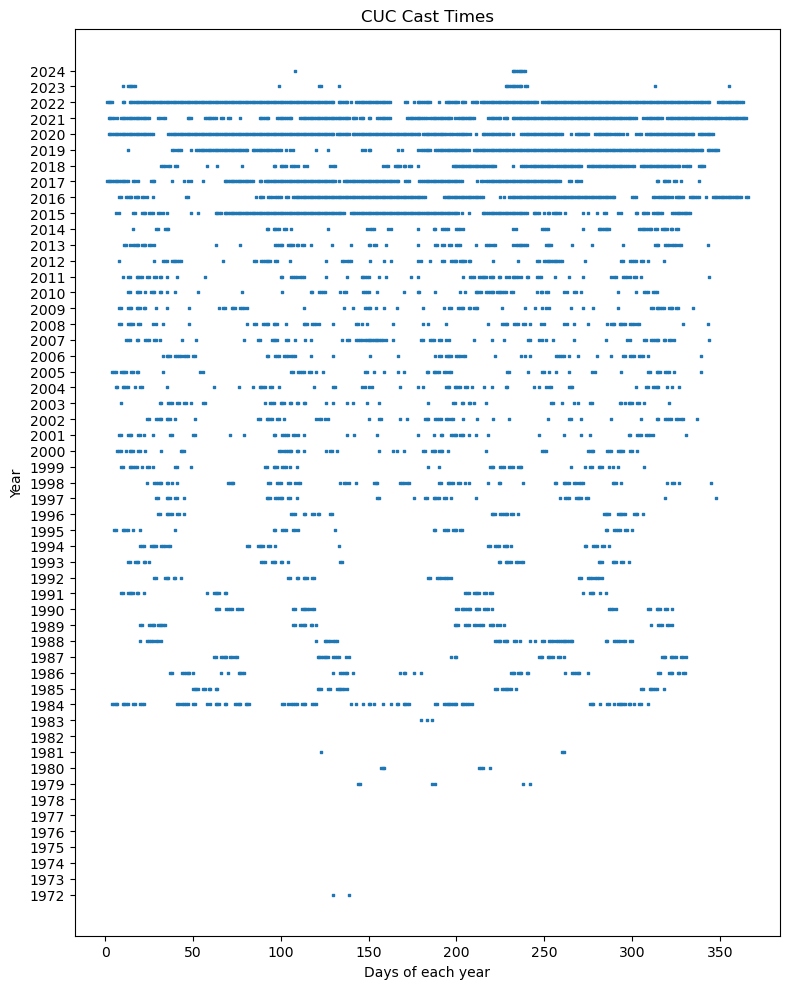

In [20]:
# Temporal resolution of California Under Current
fig, ax = plt.subplots(figsize=(8, 10))

obs_cuc_dd = obs_cuc.drop_duplicates(subset='time', keep='first')

obs_cuc_dd['time'] = pd.to_datetime(obs_cuc_dd['time'])

yearDay = obs_cuc_dd['time'].dt.dayofyear
year = obs_cuc_dd['time'].dt.year

ax.scatter(yearDay, year, s=2, marker='s' )
# ax.scatter(yearDay, year, s=2, marker='s', c=obs_cuc['month'], cmap='viridis')

ax.set_title('CUC Cast Times')
ax.set_yticks(range(1972, 2025))  
ax.set_ylabel('Year')
ax.set_xlabel('Days of each year')


plt.tight_layout()
plt.show()

# Print results year by year
with open(OUTPATH+'/'+"CUC_YearSource.txt", "w") as file:
    for year in sorted(grouped['year'].unique()):
        file.write(f"\n\nIn {year} there is:")
        sub = grouped[grouped['year'] == year]
        for _, row in sub.iterrows():
            file.write(f"\n    {row['source']}: {row['count']}")

Text(0.5, 1.0, 'Shelf Current Data Density')

Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #491 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

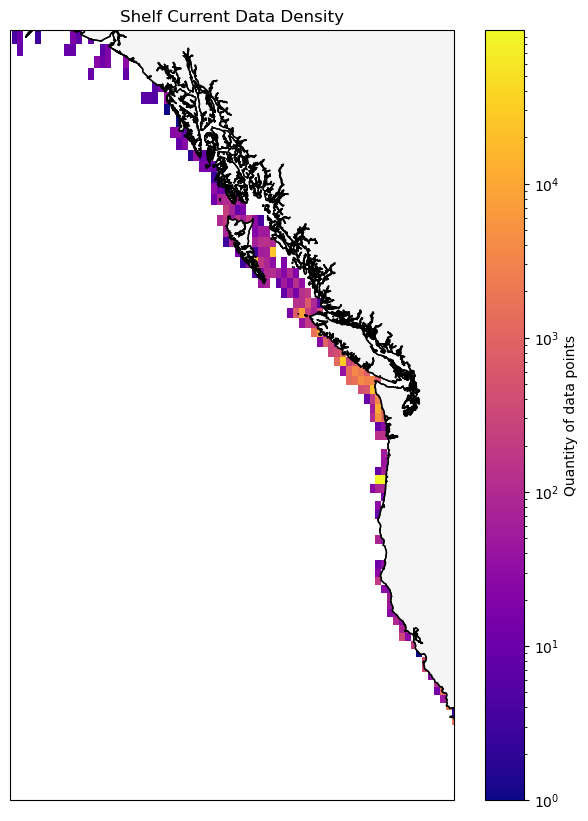

In [9]:
# Shelf Current Spatial Density
xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# Prepare your data
lon = obs_shelf['longitude (degrees_east)']
lat = obs_shelf['latitude (degrees_north)']

# Create 2D histogram
hist, xedges, yedges = np.histogram2d(lon, lat, bins=100)

# Convert bin edges to meshgrid
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters)

# Plot using pcolormesh
pcm = ax.pcolormesh(X, Y, hist.T, cmap='plasma', norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax, label="Quantity of data points")

ax.set_title('Shelf Current Data Density')

Text(0.5, 1.0, 'California Current Data Density')

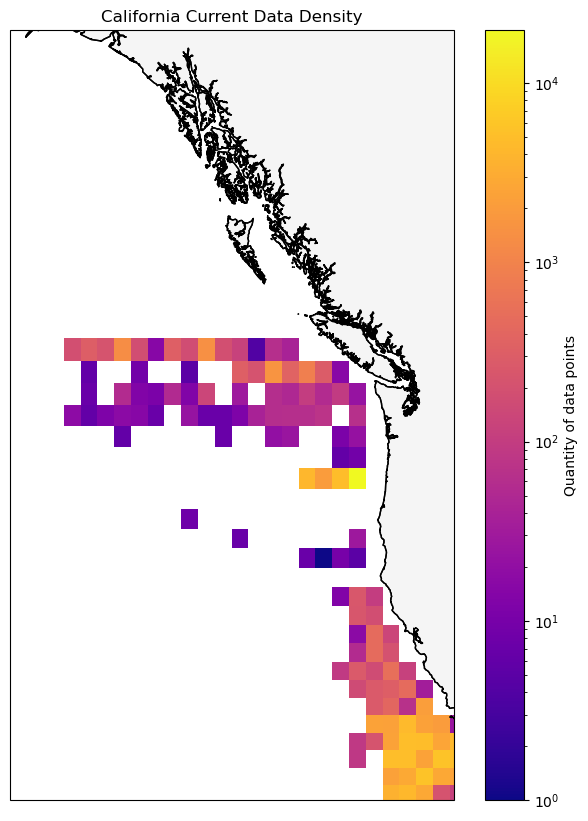

In [10]:
# CC Spatial Density
xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# Prepare data
lon = obs_cc['longitude (degrees_east)']
lat = obs_cc['latitude (degrees_north)']

# Create 2D histogram
hist, xedges, yedges = np.histogram2d(lon, lat, bins=30)

# Convert bin edges to meshgrid
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters)

# Plot using pcolormesh
pcm = ax.pcolormesh(X, Y, hist.T, cmap='plasma', norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax, label="Quantity of data points")

ax.set_title('California Current Data Density')

Text(0.5, 1.0, 'California Undercurrent Data Density')

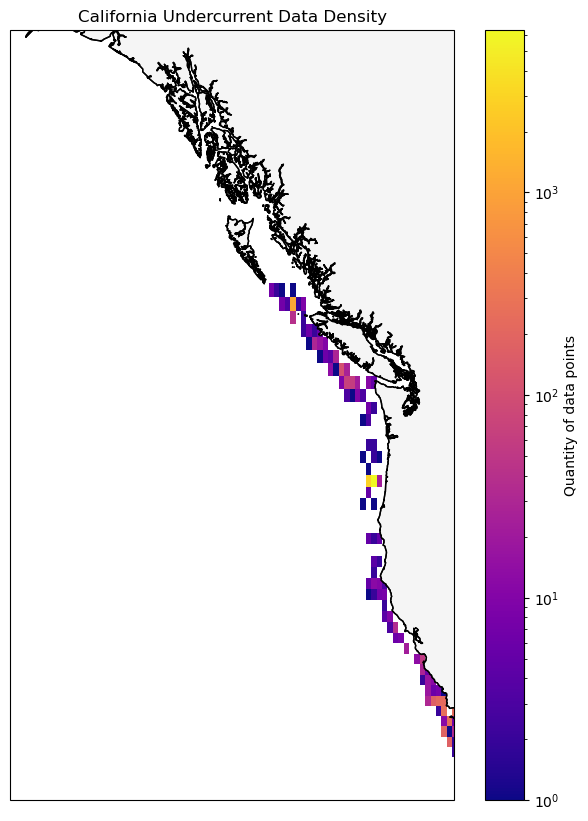

In [11]:
# CUC Spatial Density
xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# Prepare data
lon = obs_cuc['longitude (degrees_east)']
lat = obs_cuc['latitude (degrees_north)']

# Create 2D histogram
hist, xedges, yedges = np.histogram2d(lon, lat, bins=50)

# Convert bin edges to meshgrid
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters)

# Plot using pcolormesh
pcm = ax.pcolormesh(X, Y, hist.T, cmap='plasma', norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax, label="Quantity of data points")

ax.set_title('California Undercurrent Data Density')

## seasonal biases at different latitudes

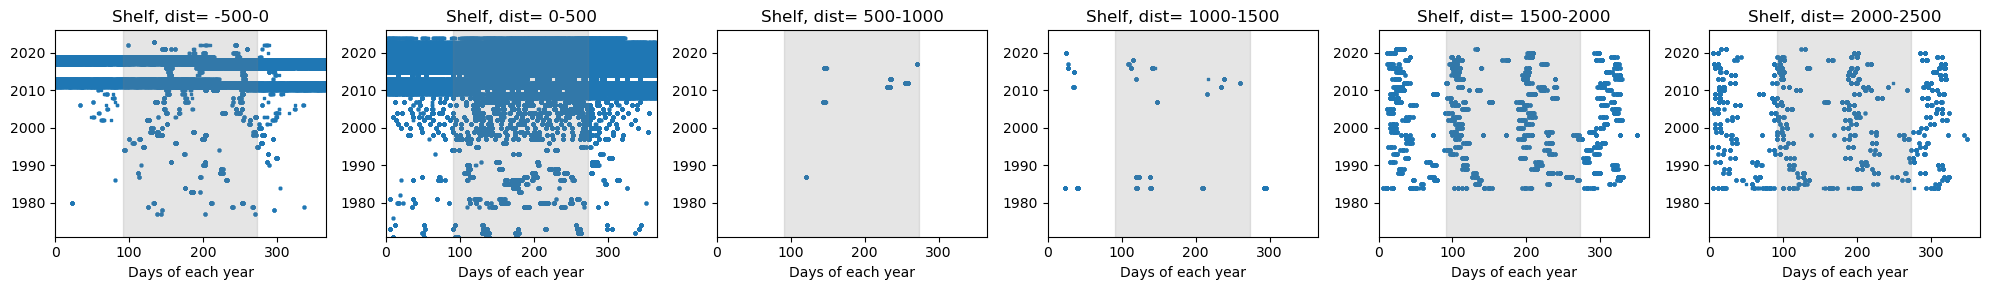

In [69]:
# Temporal resolution of shelf
obs_used = obs_shelf
yearDay = obs_used['time'].dt.dayofyear
year = obs_used['year']

dbins = np.arange(-500,2501,500)
fig, ax = plt.subplots(1,len(dbins)-1,figsize=[20,3])

for i in range(len(dbins)-1):
    idx = (obs_used.dist>=dbins[i])&(obs_used.dist<dbins[i+1])
    if sum(idx)==0:
        continue

    ax[i].scatter(yearDay[idx], year[idx], s=2, marker='s' )
    ax[i].fill_between(np.arange(1,366,1),1971,2026,where=(np.arange(1,366,1)>90)&(np.arange(1,366,1)<=273),color='grey',alpha=0.2) # april to end of september?


    ax[i].set_title('Shelf, dist= {}-{}'.format(dbins[i],dbins[i+1]))
    # ax[i].set_yticks(range(1972, 2025)) 
    ax[i].set_ylim([1971,2026]) 
    ax[i].set_xlim([0,366])
    # ax[i].set_ylabel('Year')
    ax[i].set_xlabel('Days of each year')


plt.tight_layout()

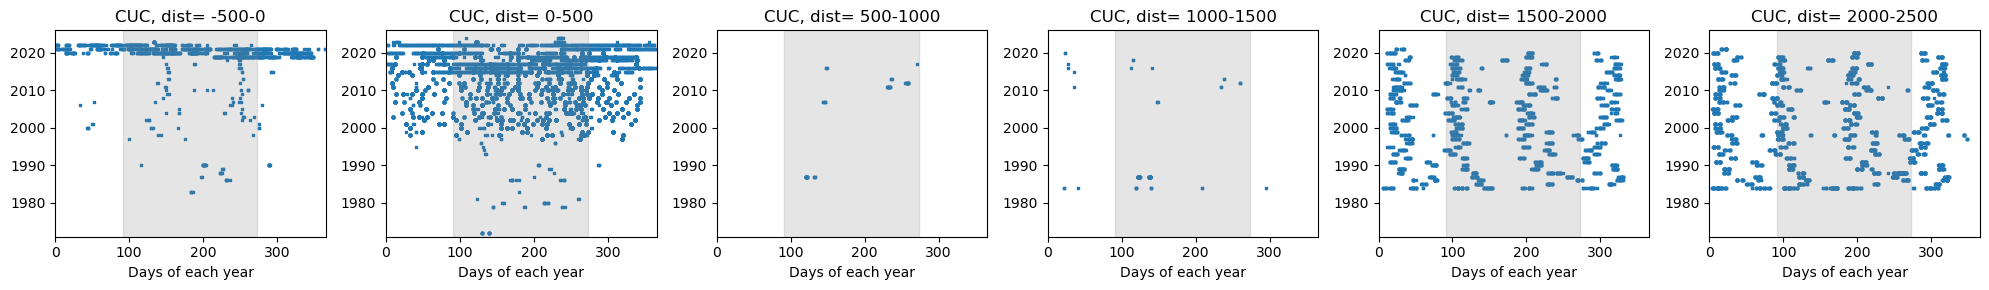

In [70]:
# Temporal resolution of California Under Current
obs_used = obs_cuc
yearDay = obs_used['time'].dt.dayofyear
year = obs_used['year']

dbins = np.arange(-500,2501,500)
fig, ax = plt.subplots(1,len(dbins)-1,figsize=[20,3])

for i in range(len(dbins)-1):
    idx = (obs_used.dist>=dbins[i])&(obs_used.dist<dbins[i+1])
    if sum(idx)==0:
        continue

    ax[i].scatter(yearDay[idx], year[idx], s=2, marker='s' )
    ax[i].fill_between(np.arange(1,366,1),1971,2026,where=(np.arange(1,366,1)>90)&(np.arange(1,366,1)<=273),color='grey',alpha=0.2)


    ax[i].set_title('CUC, dist= {}-{}'.format(dbins[i],dbins[i+1]))
    # ax[i].set_yticks(range(1972, 2025)) 
    ax[i].set_ylim([1971,2026]) 
    ax[i].set_xlim([0,366])
    # ax[i].set_ylabel('Year')
    ax[i].set_xlabel('Days of each year')


plt.tight_layout()

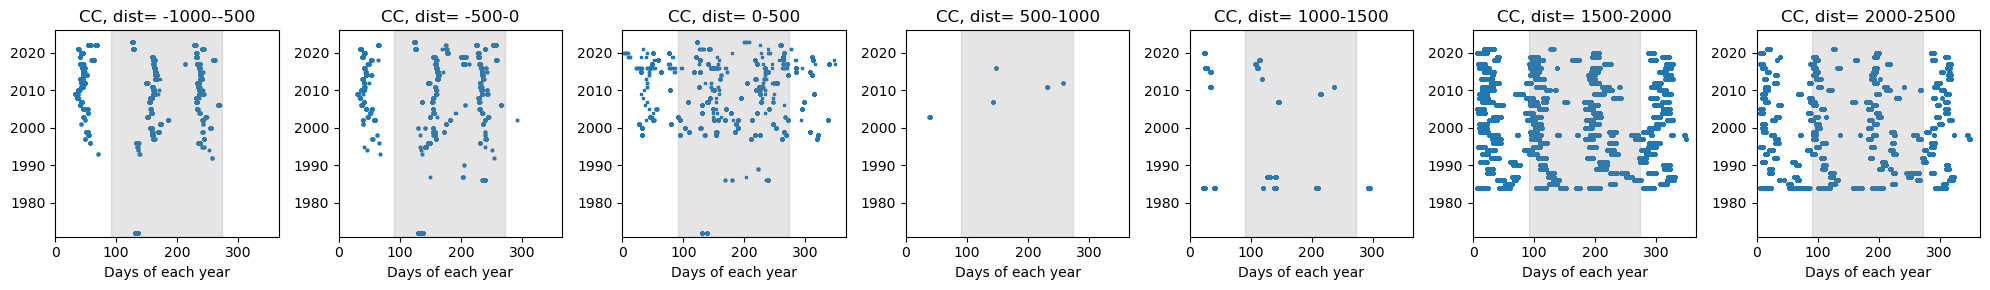

In [71]:
# Temporal resolution of California Under Current
obs_used = obs_cc
yearDay = obs_used['time'].dt.dayofyear
year = obs_used['year']

dbins = np.arange(-1000,2501,500)
fig, ax = plt.subplots(1,len(dbins)-1,figsize=[20,3])

for i in range(len(dbins)-1):
    idx = (obs_used.dist>=dbins[i])&(obs_used.dist<dbins[i+1])
    if sum(idx)==0:
        continue

    ax[i].scatter(yearDay[idx], year[idx], s=2, marker='s' )
    ax[i].fill_between(np.arange(1,366,1),1971,2026,where=(np.arange(1,366,1)>90)&(np.arange(1,366,1)<=273),color='grey',alpha=0.2)


    ax[i].set_title('CC, dist= {}-{}'.format(dbins[i],dbins[i+1]))
    # ax[i].set_yticks(range(1972, 2025)) 
    ax[i].set_ylim([1971,2026]) 
    ax[i].set_xlim([0,366])
    # ax[i].set_ylabel('Year')
    ax[i].set_xlabel('Days of each year')


plt.tight_layout()

## Average Temp Depth Profiles

In [26]:
def avg_profile_4seasons_depth(obs_used, depth_ranges, variable_str):
    """
    Takes a dataframe of observations and specifies a variable to look at, then depth bins avgs at 4 times in a year
    
    Parameters
    ----------
    obs_used : 
        datafame of observations in format of obs above
    depth_ranges :
        numpy array of depth ranges ex [0, 20, 40, ..., 180, 200]
    variable_str :
        name of specified column in obs we are averaging ex 'temperature (degC)'
    
    Returns
    -------
    profile_avg
        avg profiles at 4 seasons
    """
    profile_avg = np.empty((4, len(depth_ranges)-1))
    for n in range(4):
        if n == 0:
            start_mon, end_mon = 1, 3
        elif n == 1:
            start_mon, end_mon = 4, 6
        elif n == 2:
            start_mon, end_mon = 7, 9
        elif n == 3:
            start_mon, end_mon = 10, 12
            
        for i in range(len(depth_ranges)-1):
            dep_mask = ((obs_used['depth (m)'] >= depth_ranges[i]) & (obs_used['depth (m)'] <= depth_ranges[i+1]) & 
                        (obs_used['months'] >= start_mon) & (obs_used['months'] <= end_mon))
            profile_avg[n,i] = np.mean(obs_used[dep_mask][variable_str])
    profile_avg =  np.array(profile_avg)
    return profile_avg

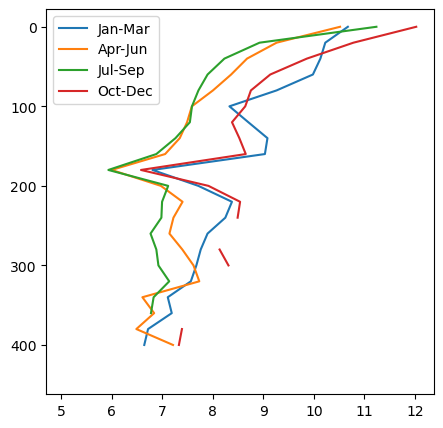

In [27]:
# Shelf Current Avg Temp Profiles
obs_used = obs_shelf

depth_ranges = np.arange(0,500,20) # Every 20m depth range
variable_str = 'temperature (degC)'

profile_clim_avg = avg_profile_4seasons_depth(obs_used, depth_ranges, variable_str)

fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.plot(profile_clim_avg.T, np.tile(depth_ranges[:-1], (4,1)).T)
ax.invert_yaxis()
ax.legend(('Jan-Mar', 'Apr-Jun', 'Jul-Sep', 'Oct-Dec'))

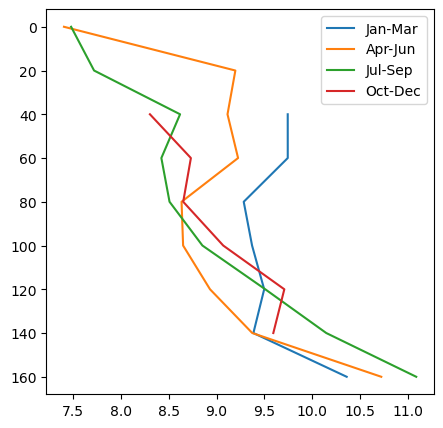

In [28]:
# California Undercurrent Avg Temp Profiles
obs_used = obs_cuc

depth_ranges = np.arange(0,500,20) # Every 20m depth range
variable_str = 'temperature (degC)'

profile_clim_avg = avg_profile_4seasons_depth(obs_used, depth_ranges, variable_str)

fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.plot(profile_clim_avg.T, np.tile(depth_ranges[:-1], (4,1)).T)
ax.invert_yaxis()
ax.legend(('Jan-Mar', 'Apr-Jun', 'Jul-Sep', 'Oct-Dec'))

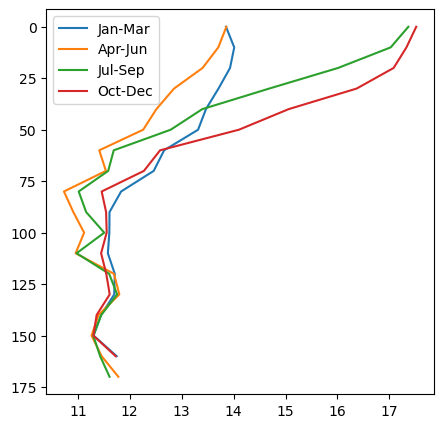

In [29]:
# California Current Avg Temp Profiles
obs_used = obs_cc

depth_ranges = np.arange(0,500,10) # Every 10m depth range
variable_str = 'temperature (degC)'

profile_clim_avg = avg_profile_4seasons_depth(obs_used, depth_ranges, variable_str)

fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.plot(profile_clim_avg.T, np.tile(depth_ranges[:-1], (4,1)).T)
ax.invert_yaxis()
ax.legend(('Jan-Mar', 'Apr-Jun', 'Jul-Sep', 'Oct-Dec'))